# Math 8803 HW2

## Problem 1 - Inter-spike Interval of a Poisson point process spike train

First, establishing some notation, we define the spike train point process as the Poisson point process $N(t)$. In other words, we interpret $N(t)$ as the number of spikes from time $0$ to $t$. Also, by the definition of a Poisson point process $N(0) = 0$. In other words, at time $t = 0$, we assume that no spikes have occurred. Furthermore, as given in the problem, the rate of this process is $r$.

Before extending to inter-spike interval times, let us first analyze the distribution of time of arrival. Then, we define $T_{1}$ as the random variable representing the time of the first arrival. A key intuition is that the probability the first arrival time is after time $t$ is equivalent to the probability that there is not arrival between time $0$ to time $t$. In other words:

$$\mathbb{P}(T_{1} > t) = \mathbb{P}(N_{t} = 0) = 1 - Poisson\_CDF(0; rt) = e^{-rt}$$

which means that $T_{1} \sim Exponential(r)$, i.e. the time of the first arrival follows an exponential distribution with rate $r$.

Now, let's look at the second arrival and see if we can generalize this distribution to times between spikes rather than between $0$ and the time of the first spike. Let $T_{2}$ be the time elapsed between the first arrival and the second arrival and let $t_{1}$ be the realized time of the first arrival. We are now interested in times $t_{2} > t_{1}$ where $t_{1} + t = t_{2}$ for some $t > 0$. Using the same argument as before, the probability that the second arrival is after time $t$ where $t_{2} + t > t_{1}$ is equivalent to the probability no spikes occur between the time interval $[t_{1}, t_{2}]$:

$$\mathbb{P}(T_{2} > t_{2} = t + t_{1}| T_{1} = t_{1}) = \mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0| T_{1} = t_{1}) $$

Another key fact we have to use about the Poisson process is that it is also memoryless, i.e. that previous arrivals shouldn't influence subsequent arrivals. Moreover, the sum of Poisson random variables is a Poisson random variable with a rate that is the sum of the rates, i.e. if $X_{i} \sim Poisson(\mu_{i})$ for $i = 1, \ldots, n$ then $X_{1} + \ldots + X_{n} \sim Poisson(\mu_{1} + \ldots + \mu_{n})$. Thus:

\begin{align*}
\mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0| T_{1} = t_{1}) &= \mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0) \\
 &= 1 - Poisson\_CDF(0; r(t_{2} - t_{1})) \\
 &= e^{-r((t + t_{1}) - t_{1})} = e^{-rt}
\end{align*}

This argument can be inductively generalized for random variables $T_{i}$ to $T_{i + 1}$ which means that the inter-spike interval follows an exponential distribution. Specifically, using the notation given in the problem, the mean of the exponential distribution is $r$ and if we are interested in finding the probability at inter-spike interval length $\delta T$ we get:

$$\mathbb{P}(\delta t) = Exponential\_PDF(\delta t; r) = re^{-r\delta t}$$


## Problem 2

## (a) Izhekevich Model

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def prob_m_exc(N_exc, r_exc, timestep):
	return np.random.binomial(N_exc, r_exc * timestep)

def prob_m_inh(N_inh, r_inh, timestep):
	if np.random.binomial(N_inh, r_inh * timestep) == 2:
		print("Yes!")
	return np.random.binomial(N_inh, r_inh * timestep)

def n_inh(t1_inh, t2_inh):
	term1 = np.power((t2_inh / t1_inh), t2_inh / (t1_inh - t2_inh))
	term2 = np.power((t2_inh / t1_inh), t1_inh / (t1_inh - t2_inh))
	return np.power((term1 - term2), -1)

def n_exc(t1_exc, t2_exc):
	term1 = np.power((t2_exc / t1_exc), t2_exc / (t1_exc - t2_exc))
	term2 = np.power((t2_exc / t1_exc), t1_exc / (t1_exc - t2_exc))
	return np.power((term1 - term2), -1)


def ode_int_izhekevich_double_exponential_synapse(p):
	np.random.seed(seed=123456789)
	T = np.arange(0, p['t_max'] + p['delta_t'], p['delta_t'])
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))

	i_s_inh = np.zeros(len(T))
	i_s_exc = np.zeros(len(T))

	a_inh = np.zeros(len(T))
	b_inh = np.zeros(len(T))
	p_s_inh = np.zeros(len(T))

	a_exc = np.zeros(len(T))
	b_exc = np.zeros(len(T))
	p_s_exc = np.zeros(len(T))

	v[0] = p['c'] #mV
	V = v[0]
	u[0] = 0
	U = u[0] 

	A_inh = 0
	B_inh = 0

	N_inh = p['N_inh']
	r_inh = p['r_inh']
	tau_1_inh = p['tau_1_inh']
	tau_2_inh = p['tau_2_inh']
	Delta_P_s_inh = p['Delta_P_s_inh']
	G_inh = p['G_inh']
	E_syn_inh = p['E_syn_inh']

	A_exc = 0
	B_exc = 0

	N_exc = p['N_exc']
	r_exc = p['r_exc']
	tau_1_exc = p['tau_1_exc']
	tau_2_exc = p['tau_2_exc']
	Delta_P_s_exc = p['Delta_P_s_exc']
	G_exc = p['G_exc']
	E_syn_exc = p['E_syn_exc']

	for i in range(1, len(T)):
		t = T[i] #(i maps to t (i, t))

		## Forward euler of times between spikes in pre-synaptic neurons
		# Inhibitatory
		A_inh += p['delta_t'] * -A_inh / tau_1_inh
		B_inh += p['delta_t'] * -B_inh / tau_2_inh

		# Excitatory
		A_exc += p['delta_t'] * -A_exc / tau_1_exc
		B_exc += p['delta_t'] * -B_exc / tau_2_exc

		## When Presynaptic Neurons Spike
		# Inhibitatory
		A_inh += prob_m_inh(N_inh, r_inh, p['delta_t']) * Delta_P_s_inh * (1 - p_s_inh[i - 1])
		B_inh += prob_m_inh(N_inh, r_inh, p['delta_t']) * Delta_P_s_inh * (1 - p_s_inh[i - 1])

		a_inh[i] = A_inh # = A_inh(t)
		b_inh[i] = B_inh # = B_inh(t)

		# Excitatory	
		A_exc += prob_m_exc(N_exc, r_exc, p['delta_t']) * Delta_P_s_exc * (1 - p_s_exc[i - 1])
		B_exc += prob_m_exc(N_exc, r_exc, p['delta_t']) * Delta_P_s_exc * (1 - p_s_exc[i - 1])

		a_exc[i] = A_exc # = A_exc(t)
		b_exc[i] = B_exc # = B_exc(t)
		
		# Synaptic Current
		p_s_inh[i] = n_inh(tau_1_inh, tau_2_inh) * (a_inh[i] - b_inh[i]) # = p_s_inh(t)
		I_s_inh = G_inh * p_s_inh[i] * (V - E_syn_inh)

		p_s_exc[i] = n_exc(tau_1_exc, tau_2_exc) * (a_exc[i] - b_exc[i]) # = p_s_exc(t)

		I_s_exc = G_exc * p_s_exc[i] * (V - E_syn_exc)
		i_s_inh[i] = I_s_inh
		i_s_exc[i] = I_s_exc

		Is = I_s_exc + I_s_inh

		# Forward euler of Izhikevich Model
		V = V + p['delta_t'] * (0.04 * pow(V, 2) + 5*V + 140 - U - Is)
		U = U + p['delta_t'] * (p['a']*(p['b']*V-U))
		I[i] = Is
		if (V >= p['voltage_threshold']):
			v[i] = 30
			V = p['c']
			U = U + p['d']
		else:
			v[i] = V
		u[i] = U

	return v, T, I, i_s_inh, i_s_exc

In [92]:
parameters_2 = {
	"a": 10,
	"b": 0,
	"c": -82.7, # V_rest in mV
	"d": 0,
	"voltage_threshold": 30, # mv
	"delta_t": 0.01, #ms
	"t_max": 200, #ms
	"N_inh": 2, 
	"r_inh": 0.1,
	"tau_1_inh": 1,
	"tau_2_inh": 0.5,
	"Delta_P_s_inh": 0.1,
	"G_inh": 5,
	"E_syn_inh": -100, #mV
	"N_exc": 2, 
	"r_exc": 0.1,
	"tau_1_exc": 0.5,
	"tau_2_exc": 0.25,
	"Delta_P_s_exc": 0.1,
	"G_exc": 5,
	"E_syn_exc": 50, #mV
}

(20001,) (20001,) (20001,)


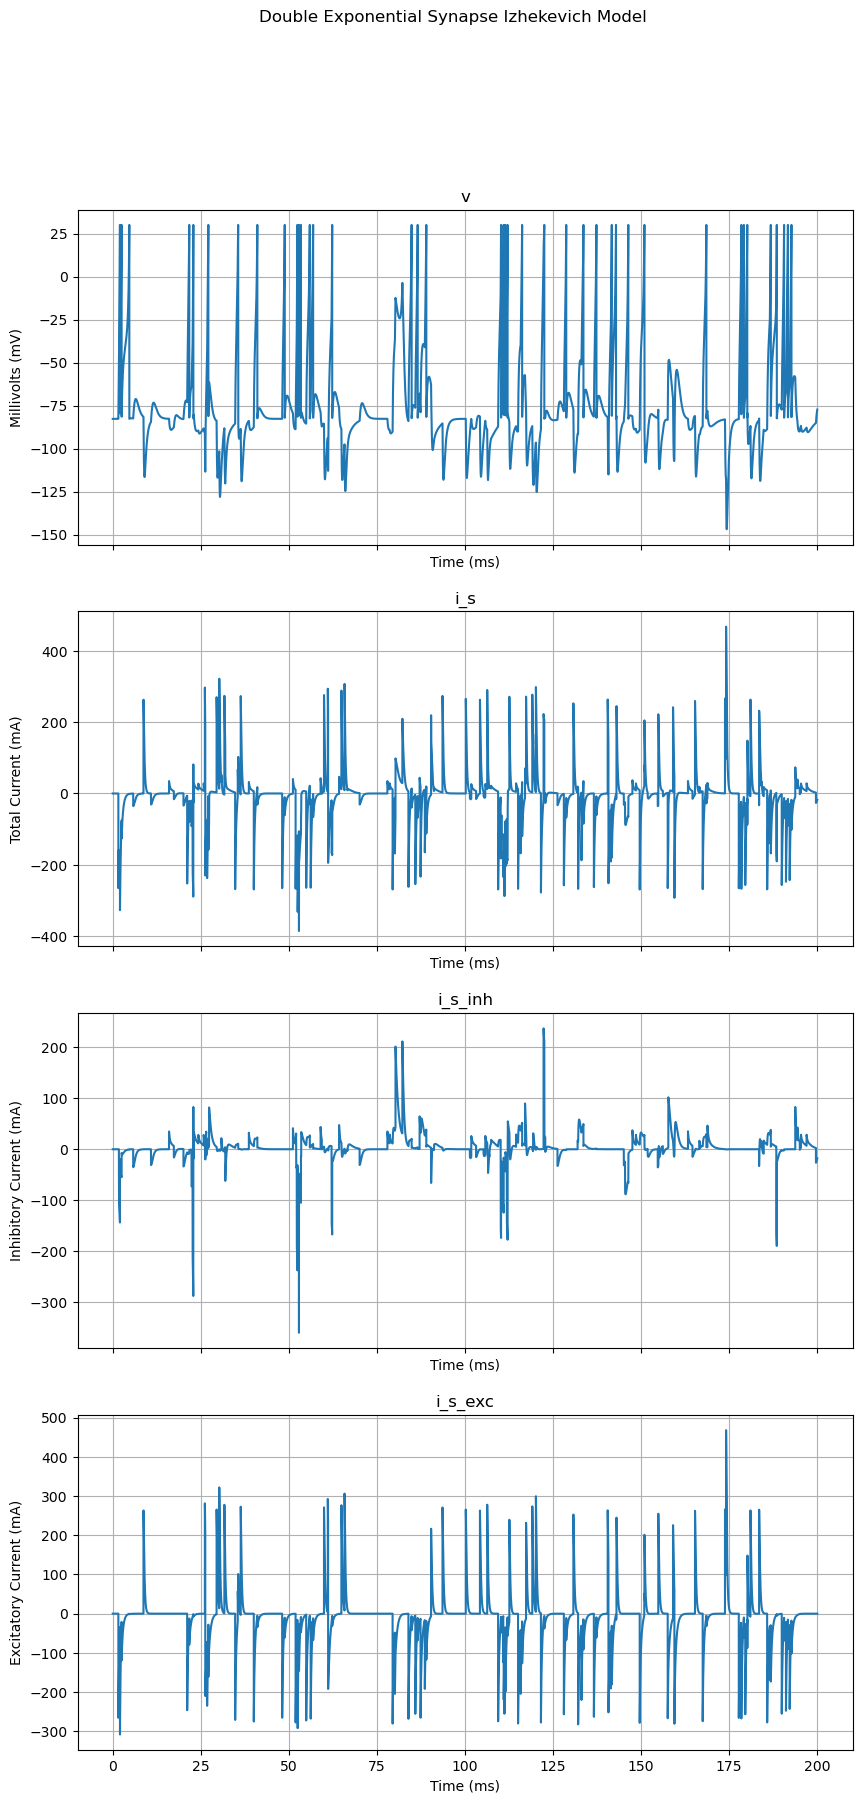

In [93]:
v, T, i, i_s_inh, i_s_exc = ode_int_izhekevich_double_exponential_synapse(parameters_2)
print(T.shape, v.shape, i.shape)
fig, axs = plt.subplots(4, sharex=True, figsize=(10,20))
fig.suptitle("Double Exponential Synapse Izhekevich Model")

axs[0].plot(T, v)
axs[0].set_title('v')
axs[0].set(xlabel="Time (ms)", ylabel="Millivolts (mV)")
axs[0].grid()

axs[1].plot(T, i)
axs[1].set_title('i_s')
axs[1].set(xlabel="Time (ms)", ylabel="Total Current (mA)")
axs[1].grid()

axs[2].plot(T, i_s_inh)
axs[2].set_title('i_s_inh')
axs[2].set(xlabel="Time (ms)", ylabel="Inhibitory Current (mA)")
axs[2].grid()

axs[3].plot(T, i_s_exc)
axs[3].set_title('i_s_exc')
axs[3].set(xlabel="Time (ms)", ylabel="Excitatory Current (mA)")
axs[3].grid()

fig.subplots_adjust(hspace=0.2)


plt.show()